In [1]:
import sys
import torch
import geoopt

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import trange
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from geoopt import linalg, ManifoldParameter, Stiefel
from geoopt.optim import RiemannianSGD, RiemannianAdam
from copy import deepcopy

sys.path.append("./lib/data")
from get_data import get_data, get_cov

# sys.path.append("./lib/spdnet")
# import nn as nn_spd
# from optimizers import MixOptimizer

sys.path.append("./lib")
from swspd import sliced_wasserstein_spd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

### Data

In [3]:
subject = 1
Xs, ys = get_data(subject, True, "./dataset/")
cov_Xs = torch.tensor(get_cov(Xs), device=device) #, dtype=torch.float32)
ys = torch.tensor(ys, device=device, dtype=torch.long)-1

Xt, yt = get_data(subject, False, "./dataset/")
cov_Xt = torch.tensor(get_cov(Xt), device=device) #, dtype=torch.float32)
yt = torch.tensor(yt, device=device, dtype=torch.long)-1

In [4]:
print(Xs.shape, cov_Xs.shape, Xt.shape, cov_Xt.shape)

(273, 22, 1750) torch.Size([273, 1, 1, 22, 22]) (281, 22, 1750) torch.Size([281, 1, 1, 22, 22])


In [5]:
d = 22
n_classes = 4

freq = 0

In [6]:
def plot_tsne(Xs, Xt, suptitle=None):
    log_Xs = linalg.sym_logm(Xs.detach().cpu()).reshape(-1, d*d)
    log_Xt = linalg.sym_logm(Xt.detach().cpu()).reshape(-1, d*d)

    log_data = torch.cat([log_Xs, log_Xt], dim=0)

    X_embedded = TSNE(n_components=2, init='random', perplexity=3).fit_transform(log_data.numpy())


    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].scatter(X_embedded[:len(log_Xs),0], X_embedded[:len(log_Xs),1], c="blue", label="Session 1")
    ax[0].scatter(X_embedded[len(log_Xs):,0], X_embedded[len(log_Xs):,1], c="red", label="Session 2")

    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==0], X_embedded[:len(log_Xs),1][ys==0], c="blue", label="Class 0")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==1], X_embedded[:len(log_Xs),1][ys==1], c="red", label="Class 1")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==2], X_embedded[:len(log_Xs),1][ys==2], c="green", label="Class 2")
    ax[1].scatter(X_embedded[:len(log_Xs),0][ys==3], X_embedded[:len(log_Xs),1][ys==3], c="yellow", label="Class 3")

    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==0], X_embedded[len(log_Xs):,1][yt==0], c="blue")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==1], X_embedded[len(log_Xs):,1][yt==1], c="red")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==2], X_embedded[len(log_Xs):,1][yt==2], c="green")
    ax[1].scatter(X_embedded[len(log_Xs):,0][yt==3], X_embedded[len(log_Xs):,1][yt==3], c="yellow")

    ax[0].legend()
    ax[1].legend()
    
    if suptitle is not None:
        plt.suptitle(suptitle)
        
    plt.show()

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


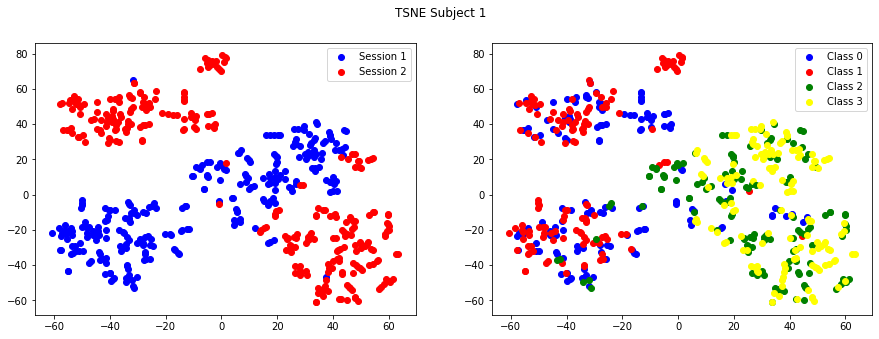

In [7]:
plot_tsne(cov_Xs[:,:,freq], cov_Xt[:,:,freq], suptitle="TSNE Subject 1")

### Learnable Transformation

In [8]:
class Translation(nn.Module):
    def __init__(self, d):
        super().__init__()
        
        manifold_spdai = geoopt.SymmetricPositiveDefinite("AIM")        
        self._W = ManifoldParameter(torch.eye(d, dtype=torch.double, device=device), manifold=manifold_spdai)
        
        with torch.no_grad():
            self._W.proj_()
        
    def forward(self, X):
        return torch.matmul(self._W, torch.matmul(X, self._W.T))
    
class Rotation(nn.Module):
    def __init__(self, d):
        super().__init__()
        
        manifold = Stiefel()        
        self._W = ManifoldParameter(torch.eye(d, dtype=torch.double, device=device), manifold=manifold)
        
        with torch.no_grad():
            self._W.proj_()
        
    def forward(self, X):
        return torch.matmul(self._W, torch.matmul(X, self._W.T))
    
class Transformations(nn.Module):
    def __init__(self, d):
        super().__init__()
        
        self.translation = Translation(d)
#         self.rescaling = Rescaling(d)
        self.rotation = Rotation(d)
    
    def forward(self, X):
        Y = self.translation(X)
#         Y = self.rescaling(Y)
        Y = self.rotation(Y)
        return Y

In [9]:
class MLP(nn.Module):
    def __init__(self, d, n_c, h, device):
        super().__init__()
        self.linear1 = nn.Linear(d, h, device=device, dtype=torch.double)
        self.linear2 = nn.Linear(h, n_c, device=device, dtype=torch.double)
        self.batch_norm = nn.BatchNorm1d(d, device=device, dtype=torch.double)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        out = self.batch_norm(X)
        out = F.relu(self.linear1(out))
        out = self.linear2(out)
        return self.sigmoid(out)

### Training Alignement

In [10]:
epochs = 500
num_projs = 500

model = Transformations(22).to(device)
optimizer = RiemannianSGD(model.parameters(), lr=1e-1)
# optimizer = RiemannianAdam(model.parameters(), lr=1e-1)

L_loss = []

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,freq])
    loss = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,freq], num_projs, device, p=2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    L_loss.append(loss.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.3f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:13<00:00,  1.98it/s, loss = 0.001]


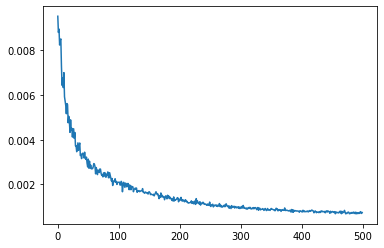

In [11]:
plt.plot(L_loss)
plt.show()

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


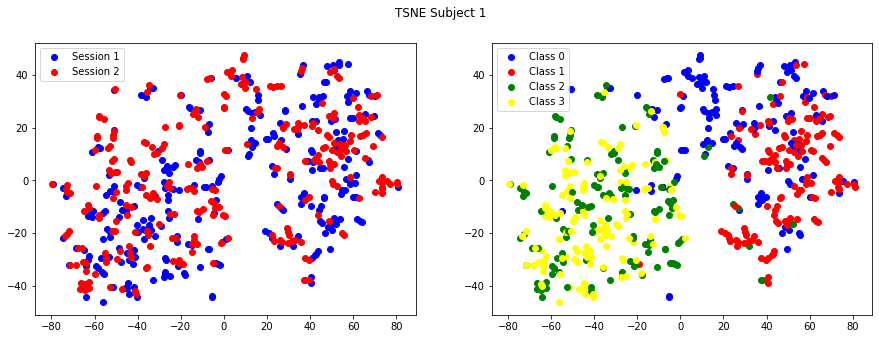

In [12]:
plot_tsne(model(cov_Xs[:,:,freq]), cov_Xt[:,:,freq], suptitle="TSNE Subject 1")

In [13]:
## k-NN on original data

log_Xs = linalg.sym_logm(cov_Xs[:,0,0].detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0].detach().cpu()).reshape(-1, d*d)

for k in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(log_Xs, ys)
    print(k, neigh.score(log_Xt, yt))

1 0.5587188612099644
2 0.6263345195729537
3 0.6654804270462633
4 0.6690391459074733
5 0.6868327402135231
6 0.6619217081850534
7 0.6903914590747331
8 0.6868327402135231
9 0.6761565836298933


In [14]:
## k-NN with target shifted on sources

log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0]).detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0].detach().cpu()).reshape(-1, d*d)

for k in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(log_Xs, ys)
    print(k, neigh.score(log_Xt, yt))

1 0.6156583629893239
2 0.6227758007117438
3 0.6761565836298933
4 0.6797153024911032
5 0.697508896797153
6 0.697508896797153
7 0.6868327402135231
8 0.7117437722419929
9 0.7224199288256228


In [15]:
## Logistic Regression on original data

log_Xs = linalg.sym_logm(cov_Xs[:,0,0].detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0].detach().cpu()).reshape(-1, d*d)

lr = LogisticRegression()
lr.fit(log_Xs, ys)
lr.score(log_Xt, yt)

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7686832740213523

In [16]:
## Logistic Regression with target shifted on sources

log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0]).detach().cpu()).reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,:,0].detach().cpu()).reshape(-1, d*d)

lr = LogisticRegression()
lr.fit(log_Xs, ys)
lr.score(log_Xt, yt)

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7864768683274022

### Alignement + Classifier

In [17]:
epochs = 500
num_projs = 500

model = Transformations(22).to(device)
classifier = MLP(d*d, 4, 50, device=device)

optimizer_riemann = RiemannianSGD(model.parameters(), lr=1e-1)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-2)

L_loss = []
L_sw = []
L_ce = []

cross_entropy = torch.nn.CrossEntropyLoss()

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,freq])
    log_Xs = linalg.sym_logm(zs[:,0,]).reshape(-1, d*d)

    sw = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,freq], num_projs, device, p=2)
    ce = 0.01 * cross_entropy(classifier(log_Xs), ys)
    loss = sw + ce
    loss.backward()
    
    optimizer_riemann.step()
    optimizer.step()
    optimizer_riemann.zero_grad()
    optimizer.zero_grad()
    
    L_loss.append(loss.item())
    L_sw.append(sw.item())
    L_ce.append(ce.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.5f}, " + f"sw = {sw.item():.5f}, " + f"ce = {ce.item():.5f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:25<00:00,  1.88it/s, loss = 0.00822, sw = 0.00078, ce = 0.00744]


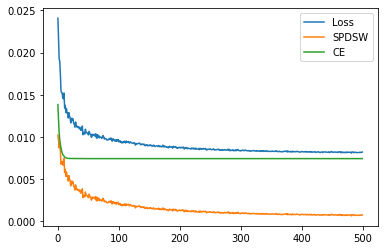

In [18]:
plt.plot(L_loss, label="Loss")
plt.plot(L_sw, label="SPDSW")
plt.plot(L_ce, label="CE")
plt.legend()
plt.show()

In [19]:
## LR on original data

log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

lr = LogisticRegressionCV(Cs=10, max_iter=1000, n_jobs=10)
lr.fit(log_Xs, ys.cpu())
lr.score(log_Xt, yt.cpu())

0.7686832740213523

In [20]:
## LR on shifted data

log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

lr = LogisticRegressionCV(Cs=10, max_iter=1000, n_jobs=10)
lr.fit(log_Xs, ys.cpu())
lr.score(log_Xt, yt.cpu())

0.800711743772242

In [21]:
acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

print(acc_target, acc_source)

0.7330960854092526 1.0


/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


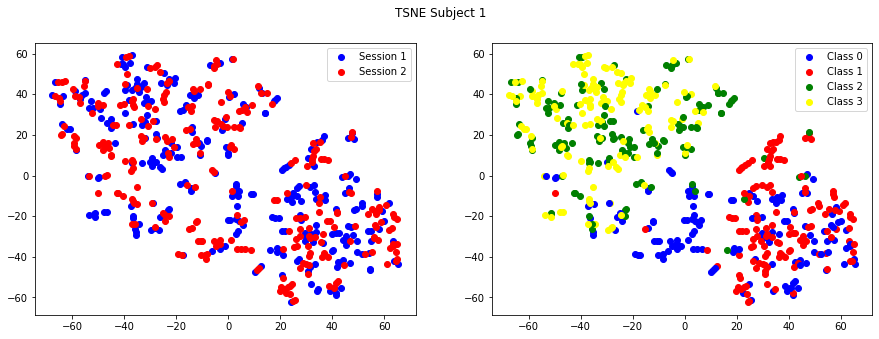

In [22]:
plot_tsne(model(cov_Xs[:,:,freq]), cov_Xt[:,:,freq], suptitle="TSNE Subject 1")

### Classifier + Alignment Marginals and Conditionals

Use pseudo labels which we obtained using a basic classifier on the source.

In [23]:
epochs = 500
num_projs = 500

model = Transformations(22).to(device)
classifier = MLP(d*d, 4, 50, device=device)

optimizer_riemann = RiemannianSGD(model.parameters(), lr=1e-1)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-2)

L_loss = []
L_sw_marg = []
L_sw_cond = []
L_ce = []

cross_entropy = torch.nn.CrossEntropyLoss()

## Base classifier trained on source
log_Xs = linalg.sym_logm(cov_Xs[:,0,0]).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)
lr = LogisticRegressionCV(Cs=10, max_iter=1000, n_jobs=10)
lr.fit(log_Xs, ys.cpu())
yt_hat = lr.predict(log_Xt) ## pseudo labels

pbar = trange(epochs)

for e in pbar:
    zs = model(cov_Xs[:,:,freq])
    log_Xs = linalg.sym_logm(zs[:,0,]).reshape(-1, d*d)

    sw_marg = sliced_wasserstein_spd(zs[:,0], cov_Xt[:,0,freq], num_projs, device, p=2)
    ce = 0.01 * cross_entropy(classifier(log_Xs), ys)
    
    sw_cond = 0
    for c in range(4):
        sw_cond += sliced_wasserstein_spd(zs[ys==c, 0], cov_Xt[yt_hat==c,0,freq], num_projs, device, p=2)/4
    
    loss = sw_marg + ce + sw_cond
    loss.backward()
    
    optimizer_riemann.step()
    optimizer.step()
    optimizer_riemann.zero_grad()
    optimizer.zero_grad()
    
    L_loss.append(loss.item())
    L_sw_marg.append(sw_marg.item())
    L_sw_cond.append(sw_cond.item())
    L_ce.append(ce.item())
    
    pbar.set_postfix_str(f"loss = {loss.item():.5f}, " + f"sw_marg = {sw_marg.item():.5f}, " 
                         + f"ce = {ce.item():.5f}, " + f"sw_cond = {sw_cond.item():.5f}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:32<00:00,  1.14s/it, loss = 0.01036, sw_marg = 0.00071, ce = 0.00744, sw_cond = 0.00221]


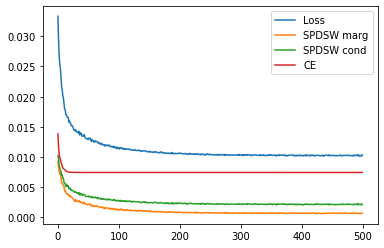

In [24]:
plt.plot(L_loss, label="Loss")
plt.plot(L_sw_marg, label="SPDSW marg")
plt.plot(L_sw_cond, label="SPDSW cond")
plt.plot(L_ce, label="CE")
plt.legend()
plt.show()

In [25]:
## LR on shifted data

log_Xs = linalg.sym_logm(model(cov_Xs[:,:,0])).detach().cpu().reshape(-1, d*d)
log_Xt = linalg.sym_logm(cov_Xt[:,0,0]).detach().cpu().reshape(-1, d*d)

lr = LogisticRegressionCV(Cs=10, max_iter=1000, n_jobs=10)
lr.fit(log_Xs, ys.cpu())
lr.score(log_Xt, yt.cpu())

0.797153024911032

In [26]:
acc_target = accuracy_score(classifier(log_Xt.to(device)).argmax(axis=1).detach().cpu(), yt.cpu())
acc_source = accuracy_score(classifier(log_Xs.to(device)).argmax(axis=1).detach().cpu(), ys.cpu())

print(acc_target, acc_source)

0.7544483985765125 1.0


/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


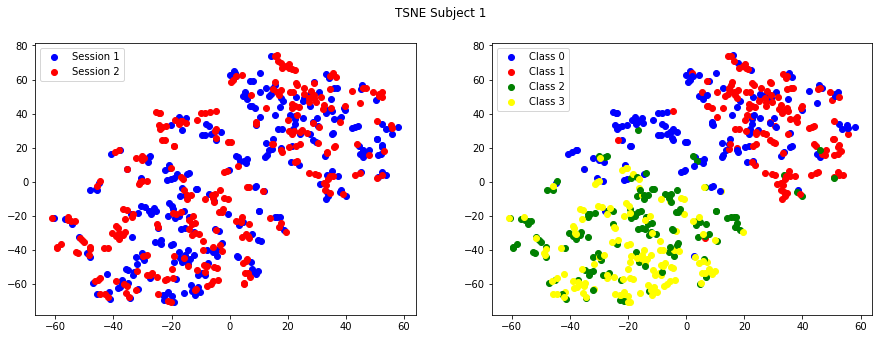

In [27]:
plot_tsne(model(cov_Xs[:,:,freq]), cov_Xt[:,:,freq], suptitle="TSNE Subject 1")